## Baseline model for bus 211

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser
import pickle
import math
%matplotlib inline
sns.set()

In [5]:
#bus_line_file = '../bus211_all.csv'

In [6]:
# convert timestamp column to pandas timestamp
df = pd.read_csv(bus_line_file)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

In [7]:
journey_ids = df['journey_number'].unique().copy()
print(journey_ids) # journeys should be ordered

# shuffle all the journey numbers
np.random.shuffle(journey_ids)
print(journey_ids) # check that journey ids are now shuffled

num_journeys = len(journey_ids)
num_train = round(num_journeys * 0.8)

# take 80% of shuffled journey ids as train, the rest as test
train_ids = journey_ids[:num_train]
test_ids = journey_ids[num_train:]

# split data into test and train by the ids
train = df[df['journey_number'].isin(train_ids)]
test = df[df['journey_number'].isin(test_ids)]

# sanity check
print('train data rows comprise {:.4f}% of the total data'.format(len(train.index) / len(df.index)))
print('test data rows comprise {:.4f}% of the total data'.format(len(test.index) / len(df.index)))

[   1    3    5 ... 1475 1476 1477]
[   9  152  688 ...  362   51 1087]
train data rows comprise 0.7978% of the total data
test data rows comprise 0.2022% of the total data


In [25]:
#pickle.dump(train, open('211_train.p', 'wb'))
#pickle.dump(test, open('211_test.p', 'wb'))

### Calculate the median travel times for each segment in the train data

In [8]:
train.head(1)

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16 07:03:00+01:00,JourneyStartedEvent,5333,211,58.417591,15.622906,-1.0,-1.0,NaN,1,1


Now lets calculate the median travel time to the station when looking at the remaining 80%, 60%, 40%, and 20% of the segment. These numbers are then used to make predictions on the unseen test data. 

We can group by `journey_number` and `segment_number`, and loop over these groups, using 5 different slices for the journey_number-segment_number unique group. Each group is equal to the data points of a single bus driving a single segment once.

In [9]:
def interval_time(x):
    """
    Get the travel time within the current segment slice/interval
    """
    timedelta = x['timestamp'].max() - x['timestamp'].min()
    return timedelta.seconds

In [10]:
data = []
for name, group in train.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    indexes = [math.floor(seg_len * i/10) for i in range(2, 10, 2)]
    interval_data = []
    for idx in indexes:
        interval_data.append(interval_time(group[idx:]))
    data.append([name[1]] + interval_data)

In [11]:
pred_df = pd.DataFrame(columns=['sn', '20_p', '40_p', '60_p', '80_p'], data=data)

In [12]:
pred_df = pred_df.groupby('sn').median().reset_index()

The `pred_df` now holds predictions for each segment number (column `sn`), and for each 20%..80% slice (columns `20_p`, `40_p`.. etc)

In [13]:
pred_df

,sn,20_p,40_p,60_p,80_p
0,1,202,151,101,50
1,2,71,54,36,17
2,3,130,98,65,32
3,4,23,17,11,5
4,5,40,30,20,10
5,6,44,33,22,11
6,7,61,46,31,15
7,8,81,61,40,20
8,9,28,22,14,7
9,10,35,26,17,8


In [14]:
pickle.dump(pred_df, open('prediction_df_203.p', 'wb'))

The dataframe above holds our median segment durations, which will be used to make predictions on the test set.

### Get the errors of the predictions on segment duration vs the actual segment durations in the test set

Now we can go through all segments in the test data for each journey and subtract the average segment time from the actual segment time. We can then calculate how big the error was, expressed as a percentage of the actual segment time. 

In [15]:
i = 0
data = []
for name, group in test.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    indexes = [math.floor(seg_len * i/10) for i in range(2, 10, 2)]
    # calculate our errors for each slice of the segment
    for idx, pred in zip(indexes, pred_df.columns[1:]):
        # get travel time to station in the slice of this segment in the test data
        seg_time = interval_time(group[idx:])
        # get error between prediction and actual travel time
        error_s = seg_time - pred_df[pred_df.sn == name[1]][pred].iloc[0]
        # get error as a percentage of the ground truth segment travel time
        error_p = error_s / seg_time * 100
        # get the absolute values of the errors in seconds and as a percentage
        abs_error_s = abs(error_s)
        abs_error_p = abs(error_p)
        data.append([name[1], pred, error_s, error_p, abs_error_s, abs_error_p])

In [16]:
error_df = pd.DataFrame(columns=['segment', 'slice', 'error_s', 'error_p', 'abs_error_s', 'abs_error_p'], data=data)

In [24]:
error_df.head(5)

,segment,slice,error_s,error_p,abs_error_s,abs_error_p
0,1,20_p,20,9.009009,20,9.009009
1,1,40_p,15,9.036145,15,9.036145
2,1,60_p,10,9.009009,10,9.009009
3,1,80_p,5,9.090909,5,9.090909
4,2,20_p,-6,-9.230769,6,9.230769


# ERROR RESULTS HERE

Dataframe above holds our prediction errors on the test set. To can now get our MAPE for the segments and the segment slices, by looking at the means of the `abs_error_p` column. The slice column values, like `20_p`, means that it's error on the prediction looking from 20% of the journey traveled until the end. `40_p` is from 40% traveled, and so on..

In [18]:
error_df.groupby('slice').mean()

,segment,error_s,error_p,abs_error_s,abs_error_p
slice,,,,,
20_p,6.5,2.649754,-1.274986,12.366236,18.701573
40_p,6.5,1.857934,-1.989919,9.475400,19.479486
60_p,6.5,1.431119,-1.561021,6.478475,20.049566
80_p,6.5,0.449569,-4.316113,3.185732,21.844099


In [19]:
error_df.groupby('segment').mean()

,error_s,error_p,abs_error_s,abs_error_p
segment,,,,
1,-0.594096,-5.233766,17.607011,16.230105
2,3.764760,-1.995939,12.080258,25.269623
3,2.987085,-0.248499,12.381919,14.955708
4,2.928044,10.294779,4.263838,22.642154
5,-0.664207,-14.065072,5.898524,28.595342
6,0.701107,-2.990409,4.649446,17.905275
7,0.022140,-3.233468,5.234317,14.466701
8,2.485240,-0.314091,9.214022,16.930636
9,0.714945,-4.785644,4.406827,26.025102


In [20]:
error_df.groupby(['segment', 'slice']).mean()

error_s    error_p  abs_error_s  abs_error_p
segment slice                                               
1       20_p  -1.210332  -5.308441    27.948339    16.036817
        40_p  -0.745387  -5.139632    21.018450    16.011443
        60_p  -0.154982  -4.981799    14.346863    16.308713
        80_p  -0.265683  -5.505193     7.114391    16.563445
2       20_p   6.501845  -0.947336    19.239852    24.569012
        40_p   4.239852  -2.290452    14.431734    24.948918
        60_p   2.520295  -3.497341     9.708487    25.597172
        80_p   1.797048  -1.248625     4.940959    25.963390
3       20_p   5.413284   0.292063    20.084871    14.958891
        40_p   3.225092  -0.494147    14.767528    14.905492
        60_p   2.173432  -0.469385     9.804428    14.921497
        80_p   1.136531  -0.322527     4.870849    15.036954
4       20_p   4.391144   9.554039     6.487085    20.437642
        40_p   3.442804   9.954310     5.051661    21.320570
        60_p   2.571956  11.009014     3.634686    22.773496
        80_p   1.306273  10.661754     1.881919    26.036907
5       20_p  -1.036900 -11.674425     9.103321    25.898180
        40_p  -0.468635 -11.286258     7.110701    26.913653
        60_p  -0.446494 -12.813373     4.874539    28.459446
        80_p  -0.704797 -20.486232     2.505535    33.110090
6       20_p   0.863469  -2.811930     7.313653    17.247922
        40_p   1.084871  -1.747473     5.623616    17.384721
        60_p   0.863469  -1.279418     3.756458    17.483967
        80_p  -0.007380  -6.122815     1.904059    19.504491
7       20_p   0.328413  -1.995373     7.996310    13.310900
        40_p   0.354244  -2.050689     6.450185    14.281466
        60_p  -0.409594  -4.295626     4.306273    14.749285
        80_p  -0.184502  -4.592185     2.184502    15.525152
8       20_p   4.059041   0.080560    14.723247    16.624613
        40_p   2.907749  -0.169070    11.062731    16.757483
        60_p   2.313653   0.745646     7.369004    16.699636
        80_p   0.660517  -1.913499     3.701107    17.640811
9       20_p   1.734317  -0.447026     6.671587    22.422512
        40_p   0.261993  -5.803663     5.199262    24.644358
        60_p   0.874539  -2.212586     3.819188    26.150724
        80_p  -0.011070 -10.679302     1.937269    30.882813
10      20_p   2.715867   3.285631     6.450185    16.145456
        40_p   2.468635   4.222430     5.287823    17.337848
        60_p   1.738007   4.458850     3.612546    17.930846
        80_p   0.878229   4.255103     1.808118    19.141766
11      20_p   2.476015   0.089929     8.970480    15.053525
        40_p   1.601476  -0.667152     6.782288    15.273002
        60_p   1.483395   0.679519     4.634686    15.586546
        80_p   0.254613  -3.161614     2.269373    16.410204
12      20_p   5.560886  -5.417524    13.405904    21.713406
        40_p   3.922509  -8.407232    10.918819    23.974873
        60_p   3.645756  -6.075749     7.874539    23.933460
        80_p   0.535055 -12.678225     3.110701    26.313165

In [30]:
error_df.groupby(['slice', 'segment']).mean()

error_s    error_p  abs_error_s  abs_error_p
slice segment                                               
20_p  1       -1.210332  -5.308441    27.948339    16.036817
      2        6.501845  -0.947336    19.239852    24.569012
      3        5.413284   0.292063    20.084871    14.958891
      4        4.391144   9.554039     6.487085    20.437642
      5       -1.036900 -11.674425     9.103321    25.898180
      6        0.863469  -2.811930     7.313653    17.247922
      7        0.328413  -1.995373     7.996310    13.310900
      8        4.059041   0.080560    14.723247    16.624613
      9        1.734317  -0.447026     6.671587    22.422512
      10       2.715867   3.285631     6.450185    16.145456
      11       2.476015   0.089929     8.970480    15.053525
      12       5.560886  -5.417524    13.405904    21.713406
40_p  1       -0.745387  -5.139632    21.018450    16.011443
      2        4.239852  -2.290452    14.431734    24.948918
      3        3.225092  -0.494147    14.767528    14.905492
      4        3.442804   9.954310     5.051661    21.320570
      5       -0.468635 -11.286258     7.110701    26.913653
      6        1.084871  -1.747473     5.623616    17.384721
      7        0.354244  -2.050689     6.450185    14.281466
      8        2.907749  -0.169070    11.062731    16.757483
      9        0.261993  -5.803663     5.199262    24.644358
      10       2.468635   4.222430     5.287823    17.337848
      11       1.601476  -0.667152     6.782288    15.273002
      12       3.922509  -8.407232    10.918819    23.974873
60_p  1       -0.154982  -4.981799    14.346863    16.308713
      2        2.520295  -3.497341     9.708487    25.597172
      3        2.173432  -0.469385     9.804428    14.921497
      4        2.571956  11.009014     3.634686    22.773496
      5       -0.446494 -12.813373     4.874539    28.459446
      6        0.863469  -1.279418     3.756458    17.483967
      7       -0.409594  -4.295626     4.306273    14.749285
      8        2.313653   0.745646     7.369004    16.699636
      9        0.874539  -2.212586     3.819188    26.150724
      10       1.738007   4.458850     3.612546    17.930846
      11       1.483395   0.679519     4.634686    15.586546
      12       3.645756  -6.075749     7.874539    23.933460
80_p  1       -0.265683  -5.505193     7.114391    16.563445
      2        1.797048  -1.248625     4.940959    25.963390
      3        1.136531  -0.322527     4.870849    15.036954
      4        1.306273  10.661754     1.881919    26.036907
      5       -0.704797 -20.486232     2.505535    33.110090
      6       -0.007380  -6.122815     1.904059    19.504491
      7       -0.184502  -4.592185     2.184502    15.525152
      8        0.660517  -1.913499     3.701107    17.640811
      9       -0.011070 -10.679302     1.937269    30.882813
      10       0.878229   4.255103     1.808118    19.141766
      11       0.254613  -3.161614     2.269373    16.410204
      12       0.535055 -12.678225     3.110701    26.313165

## Plotting histograms of our errors

#### Percentage errors

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


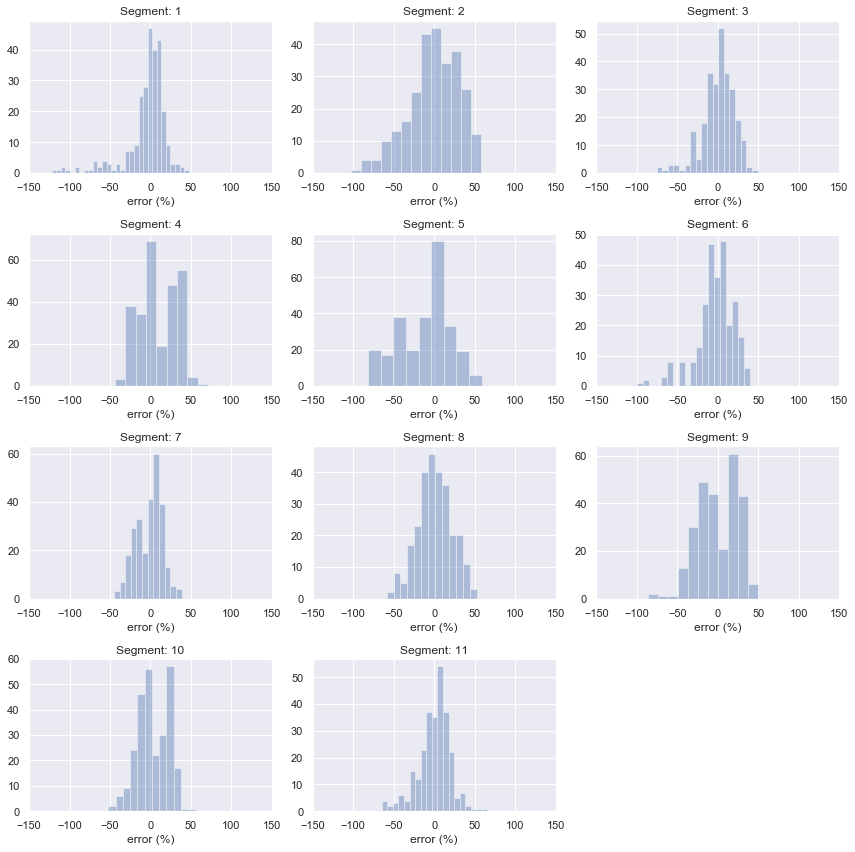

In [21]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_p, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()

#### Errors in seconds

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


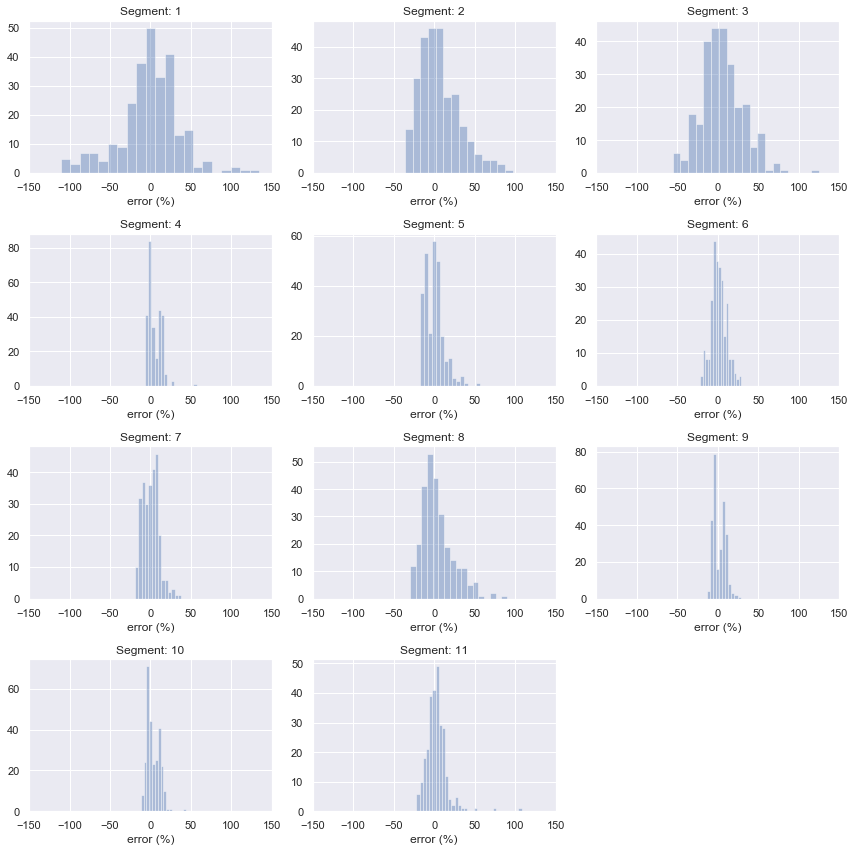

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_s, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()